In [21]:
import os
import zipfile
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPool2D, Reshape
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [22]:
archive_path = 'archive.zip'

extracted_path = 'extracted_data'

with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

train_data_dir = os.path.join(extracted_path, 'train')

test_data_dir = os.path.join(extracted_path, 'test')

In [23]:
# Функция для загрузки данных из папки
def load_data(data_dir):
    # Список эмоций
    emotions = ['angry', 'happy', 'neutral', 'sad', 'fear']
    
    # Инициализация списков для изображений и их меток
    images = []
    labels = []
    
    # Проход по каждой эмоции
    for idx, emotion in enumerate(emotions):
        # Путь к папке с изображениями для данной эмоции
        emotion_dir = os.path.join(data_dir, emotion)
        
        # Проход по каждому изображению в папке
        for img_name in os.listdir(emotion_dir):
            img_path = os.path.join(emotion_dir, img_name)
            # Загрузка изображения
            img = cv2.imread(img_path)
            # Преобразование изображения в оттенки серого
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Добавление изображения и его метки в списки
            images.append(img_gray)
            labels.append(idx)  # Используем индекс эмоции в списке эмоций как метку
    
    # Преобразование списков в массивы NumPy
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [24]:
X_train, y_train = load_data(train_data_dir)


X_test, y_test = load_data(test_data_dir)

# Добавление размерности каналов
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [25]:
# Преобразование меток в формат one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Нормализация 
X_train = X_train / 255.0
X_test = X_test / 255.0

class_num = 5

In [26]:
print(X_train.shape[1:])

(48, 48, 1)


In [27]:
model = Sequential()
#block 1
model.add(Reshape((48,48,1),input_shape=X_train.shape[1:]))
model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_normal',activation = 'elu', input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer='he_normal',activation = 'elu'))
model.add(BatchNormalization())
model.add(MaxPool2D( (2,2), padding = 'same'))
model.add(Dropout(0.5))
#block 2
model.add(Conv2D(64, (3, 3), padding = 'same',kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding = 'same', kernel_initializer='he_normal',activation = 'elu'))
model.add(BatchNormalization())
model.add(MaxPool2D( (2,2), padding = 'same'))
model.add(Dropout(0.5))
#block 3
model.add(Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(MaxPool2D( (2,2), padding = 'same'))
model.add(Dropout(0.5))
#block 4
model.add(Conv2D(256, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(MaxPool2D( (2,2), padding = 'same'))
model.add(Dropout(0.5))
#block 5
model.add(Conv2D(512, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(MaxPool2D( (2,2), padding = 'same'))
model.add(Dropout(0.5))
#Block6
model.add(Conv2D(1024, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(Conv2D(1024, (3, 3), padding = 'same', kernel_initializer='he_normal', activation = 'elu'))
model.add(BatchNormalization())
model.add(MaxPool2D( (2,2), padding = 'same'))
model.add(Dropout(0.5))
#
model.add(Flatten())
model.add(Dense(512, kernel_initializer='he_normal', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#
model.add(Flatten())
model.add(Dense(256, kernel_initializer='he_normal', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#block7
model.add(Dense(128, kernel_initializer='he_normal', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#block8
model.add(Dense(64, kernel_initializer='he_normal', activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#block8
model.add(Dense(5, activation = 'softmax'))

In [28]:
checkpoint = ModelCheckpoint('C:/Emotion_5.k',
                           monitor='val_loss',
                           mode='min',
                           save_best_only=True,
                           verbose=1)

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=5,
                            verbose=1,
                            min_lr=1e-7)

In [30]:
callbacks = [checkpoint,reduce_lr]

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# если sparce_categorical_crossentropy , callbacks то не работает

In [32]:
history = model.fit(X_train, y_train, batch_size=32, epochs = 35, validation_data = (X_test, y_test),callbacks=callbacks)

Epoch 1/35
785/785 [==============================] - ETA: 0s - loss: 1.8726 - accuracy: 0.2284
Epoch 1: val_loss improved from inf to 1.57676, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1240s 2s/step - loss: 1.8726 - accuracy: 0.2284 - val_loss: 1.5768 - val_accuracy: 0.2845 - lr: 0.0010
Epoch 2/35
785/785 [==============================] - ETA: 0s - loss: 1.5967 - accuracy: 0.2683
Epoch 2: val_loss improved from 1.57676 to 1.56849, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1208s 2s/step - loss: 1.5967 - accuracy: 0.2683 - val_loss: 1.5685 - val_accuracy: 0.2923 - lr: 0.0010
Epoch 3/35
785/785 [==============================] - ETA: 0s - loss: 1.5671 - accuracy: 0.2899
Epoch 3: val_loss did not improve from 1.56849
785/785 [==============================] - 1143s 1s/step - loss: 1.5671 - accuracy: 0.2899 - val_loss: 1.6742 - val_accuracy: 0.3055 - lr: 0.0010
Epoch 4/35
785/785 [==============================] - ETA: 0s - loss: 1.4351 - accuracy: 0.3897
Epoch 4: val_loss improved from 1.56849 to 1.34076, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1159s 1s/step - loss: 1.4351 - accuracy: 0.3897 - val_loss: 1.3408 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 5/35
785/785 [==============================] - ETA: 0s - loss: 1.3077 - accuracy: 0.4526
Epoch 5: val_loss improved from 1.34076 to 1.23433, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1156s 1s/step - loss: 1.3077 - accuracy: 0.4526 - val_loss: 1.2343 - val_accuracy: 0.4897 - lr: 0.0010
Epoch 6/35
785/785 [==============================] - ETA: 0s - loss: 1.2468 - accuracy: 0.4846
Epoch 6: val_loss did not improve from 1.23433
785/785 [==============================] - 1155s 1s/step - loss: 1.2468 - accuracy: 0.4846 - val_loss: 1.2395 - val_accuracy: 0.4907 - lr: 0.0010
Epoch 7/35
785/785 [==============================] - ETA: 0s - loss: 1.2111 - accuracy: 0.5075
Epoch 7: val_loss improved from 1.23433 to 1.15218, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1145s 1s/step - loss: 1.2111 - accuracy: 0.5075 - val_loss: 1.1522 - val_accuracy: 0.5318 - lr: 0.0010
Epoch 8/35
785/785 [==============================] - ETA: 0s - loss: 1.1839 - accuracy: 0.5231
Epoch 8: val_loss improved from 1.15218 to 1.12655, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1145s 1s/step - loss: 1.1839 - accuracy: 0.5231 - val_loss: 1.1266 - val_accuracy: 0.5311 - lr: 0.0010
Epoch 9/35
785/785 [==============================] - ETA: 0s - loss: 1.1617 - accuracy: 0.5316
Epoch 9: val_loss improved from 1.12655 to 1.10900, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1147s 1s/step - loss: 1.1617 - accuracy: 0.5316 - val_loss: 1.1090 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 10/35
785/785 [==============================] - ETA: 0s - loss: 1.1420 - accuracy: 0.5476
Epoch 10: val_loss improved from 1.10900 to 1.09607, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1145s 1s/step - loss: 1.1420 - accuracy: 0.5476 - val_loss: 1.0961 - val_accuracy: 0.5595 - lr: 0.0010
Epoch 11/35
785/785 [==============================] - ETA: 0s - loss: 1.1176 - accuracy: 0.5603
Epoch 11: val_loss improved from 1.09607 to 1.06944, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1144s 1s/step - loss: 1.1176 - accuracy: 0.5603 - val_loss: 1.0694 - val_accuracy: 0.5717 - lr: 0.0010
Epoch 12/35
785/785 [==============================] - ETA: 0s - loss: 1.1054 - accuracy: 0.5689
Epoch 12: val_loss improved from 1.06944 to 1.06827, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1139s 1s/step - loss: 1.1054 - accuracy: 0.5689 - val_loss: 1.0683 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 13/35
785/785 [==============================] - ETA: 0s - loss: 1.0866 - accuracy: 0.5796
Epoch 13: val_loss improved from 1.06827 to 1.03387, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1143s 1s/step - loss: 1.0866 - accuracy: 0.5796 - val_loss: 1.0339 - val_accuracy: 0.5928 - lr: 0.0010
Epoch 14/35
785/785 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.5902
Epoch 14: val_loss did not improve from 1.03387
785/785 [==============================] - 1137s 1s/step - loss: 1.0689 - accuracy: 0.5902 - val_loss: 1.0371 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 15/35
785/785 [==============================] - ETA: 0s - loss: 1.0613 - accuracy: 0.5947
Epoch 15: val_loss improved from 1.03387 to 1.02216, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1139s 1s/step - loss: 1.0613 - accuracy: 0.5947 - val_loss: 1.0222 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 16/35
785/785 [==============================] - ETA: 0s - loss: 1.0339 - accuracy: 0.6060
Epoch 16: val_loss improved from 1.02216 to 1.01339, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1145s 1s/step - loss: 1.0339 - accuracy: 0.6060 - val_loss: 1.0134 - val_accuracy: 0.6002 - lr: 0.0010
Epoch 17/35
785/785 [==============================] - ETA: 0s - loss: 1.0174 - accuracy: 0.6172
Epoch 17: val_loss improved from 1.01339 to 1.01051, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1145s 1s/step - loss: 1.0174 - accuracy: 0.6172 - val_loss: 1.0105 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 18/35
785/785 [==============================] - ETA: 0s - loss: 1.0008 - accuracy: 0.6245
Epoch 18: val_loss improved from 1.01051 to 0.99535, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1149s 1s/step - loss: 1.0008 - accuracy: 0.6245 - val_loss: 0.9954 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 19/35
785/785 [==============================] - ETA: 0s - loss: 0.9934 - accuracy: 0.6293
Epoch 19: val_loss improved from 0.99535 to 0.97370, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1142s 1s/step - loss: 0.9934 - accuracy: 0.6293 - val_loss: 0.9737 - val_accuracy: 0.6193 - lr: 0.0010
Epoch 20/35
785/785 [==============================] - ETA: 0s - loss: 0.9697 - accuracy: 0.6382
Epoch 20: val_loss did not improve from 0.97370
785/785 [==============================] - 1143s 1s/step - loss: 0.9697 - accuracy: 0.6382 - val_loss: 0.9867 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 21/35
785/785 [==============================] - ETA: 0s - loss: 0.9585 - accuracy: 0.6420
Epoch 21: val_loss did not improve from 0.97370
785/785 [==============================] - 1144s 1s/step - loss: 0.9585 - accuracy: 0.6420 - val_loss: 0.9967 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 22/35
785/785 [==============================] - ETA: 0s - loss: 0.9430 - accuracy: 0.6483
Epoch 22: val_loss did not improve from 0.97370
785/785 [==============================] - 1143s 1s/step - loss: 0.9430 - accuracy: 0.6483 - val_loss: 0.9765 - val_accuracy: 0

INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1146s 1s/step - loss: 0.9315 - accuracy: 0.6537 - val_loss: 0.9599 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 24/35
785/785 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.6595
Epoch 24: val_loss improved from 0.95986 to 0.95290, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1150s 1s/step - loss: 0.9158 - accuracy: 0.6595 - val_loss: 0.9529 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 25/35
785/785 [==============================] - ETA: 0s - loss: 0.9110 - accuracy: 0.6652
Epoch 25: val_loss improved from 0.95290 to 0.94955, saving model to C:/Emotion_5.k
INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1156s 1s/step - loss: 0.9110 - accuracy: 0.6652 - val_loss: 0.9495 - val_accuracy: 0.6365 - lr: 0.0010
Epoch 26/35
785/785 [==============================] - ETA: 0s - loss: 0.8850 - accuracy: 0.6753
Epoch 26: val_loss did not improve from 0.94955
785/785 [==============================] - 1150s 1s/step - loss: 0.8850 - accuracy: 0.6753 - val_loss: 0.9769 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 27/35
785/785 [==============================] - ETA: 0s - loss: 0.8773 - accuracy: 0.6798
Epoch 27: val_loss did not improve from 0.94955
785/785 [==============================] - 1151s 1s/step - loss: 0.8773 - accuracy: 0.6798 - val_loss: 0.9581 - val_accuracy: 0.6366 - lr: 0.0010
Epoch 28/35
785/785 [==============================] - ETA: 0s - loss: 0.8674 - accuracy: 0.6823
Epoch 28: val_loss did not improve from 0.94955
785/785 [==============================] - 1276s 2s/step - loss: 0.8674 - accuracy: 0.6823 - val_loss: 0.9548 - val_accuracy: 0

INFO:tensorflow:Assets written to: C:/Emotion_5.k\assets


785/785 [==============================] - 1386s 2s/step - loss: 0.8404 - accuracy: 0.6907 - val_loss: 0.9382 - val_accuracy: 0.6427 - lr: 0.0010
Epoch 31/35
785/785 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.7005
Epoch 31: val_loss did not improve from 0.93817
785/785 [==============================] - 1297s 2s/step - loss: 0.8259 - accuracy: 0.7005 - val_loss: 0.9514 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 32/35
785/785 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7061
Epoch 32: val_loss did not improve from 0.93817
785/785 [==============================] - 1133s 1s/step - loss: 0.8121 - accuracy: 0.7061 - val_loss: 0.9611 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 33/35
785/785 [==============================] - ETA: 0s - loss: 0.8012 - accuracy: 0.7089
Epoch 33: val_loss did not improve from 0.93817
785/785 [==============================] - 1134s 1s/step - loss: 0.8012 - accuracy: 0.7089 - val_loss: 0.9487 - val_accuracy: 0

In [20]:
model.save('last_epoch_5.k')

INFO:tensorflow:Assets written to: last_epoch.k\assets


INFO:tensorflow:Assets written to: last_epoch.k\assets


In [21]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 71.49%


In [23]:
import matplotlib.pyplot as plt

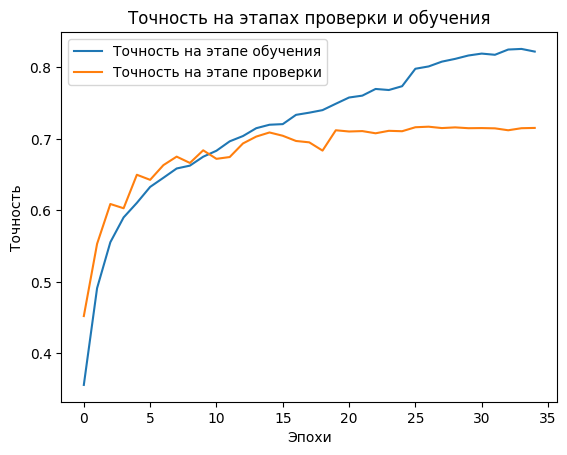

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность на этапах проверки и обучения')
plt.ylabel('Точность')
plt.xlabel('Эпохи')
plt.legend(['Точность на этапе обучения', 'Точность на этапе проверки'], loc='upper left')
plt.show()

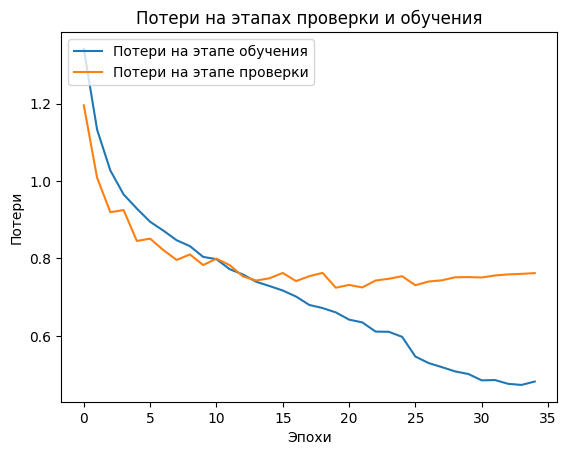

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Потери на этапах проверки и обучения')
plt.ylabel('Потери')
plt.xlabel('Эпохи')
plt.legend(['Потери на этапе обучения', 'Потери на этапе проверки'], loc='upper left')
plt.show()